In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense


Using TensorFlow backend.


In [2]:
def list_files(startpath, return_neutral = False):

    all_files = []
    neutral_files = []
    for root, dirs, files in os.walk(startpath):
        files = sorted(files)
        if files and files[-1][-4] == '.' and files[0][-4] == '.':
            all_files.append(root + '/' + files[-1])
            neutral_files.append(root + '/' + files[0])

    if return_neutral:
        return sorted(all_files), sorted(neutral_files)
    else:
        return sorted(all_files)

In [3]:
def find_matching(X, y):
    final_X = []
    final_y = []
    i, j = 0, 0
    while i < len(X):
        X_split = X[i].split('/')
        y_split = y[j].split('/')
        if X_split[3] == y_split[3] and X_split[4] == y_split[4]:
            final_X.append(X[i])
            final_y.append(y[j])
            j+=1
        i+=1
    return final_X, final_y

In [4]:
def read_Y(y):
    res_y = []
    for file in y:
        with open(file) as f:
            for line in f.readlines():
                res_y.append(float(line))
    return np.array(res_y)
    

In [5]:
def read_X(X):
    res_X = []
    try:
        for file in X:
            img = cv2.imread(file,1) # reads image as color
            img = face_reduction(img)
            res_X.append(img)
    except Exception as e:
        print("Exception in X")
        print(X)
    return np.array(res_X)

In [6]:
def detectFaceOpenCVDnn(net, frame):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)
    net.setInput(blob)
    detections = net.forward()
#     bboxes = []
    conf_threshold = 0.7
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
#             bboxes.append([x1, y1, x2, y2])
            if x1 > frameWidth or x1 < 0 or x2 > frameWidth or x2 < 0:
                continue
            else:
#                 print(frameOpencvDnn.shape)
#                 print(frameOpencvDnn)
                grayOpenDnn = gray = cv2.cvtColor(frameOpencvDnn, cv2.COLOR_BGR2GRAY)
                croppedOpenDnn = cv2.resize(gray[y1:y2,x1:x2], (200,200)) 
#                 cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return croppedOpenDnn

In [7]:
def face_reduction(image):
    # OpenCV DNN supports 2 networks.
    # 1. FP16 version of the original caffe implementation ( 5.4 MB )
    # 2. 8 bit Quantized version using Tensorflow h( 2.7 MB )
#     print("printing image")
#     print(image)
    DNN = "TF"
    if DNN == "CAFFE":
        modelFile = "models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
        configFile = "models/deploy.prototxt"
        net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    else:
        modelFile = "models/opencv_face_detector_uint8.pb"
        configFile = "models/opencv_face_detector.pbtxt"
        net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

    conf_threshold = 0.7
    outOpencvDnn = detectFaceOpenCVDnn(net,image)
    return outOpencvDnn

In [27]:
y_translation = {0:"neutral", 1:"anger", 2:"contempt", 3:"disgust", 4:"fear", 5:"happy", 6:"sadness", 7:"surprise"}
X, X_neutral = list_files('../Data/cohn-kanade-images/', return_neutral= True)
y = list_files('../Data/Emotion/')
X, y = find_matching(X, y)
y = read_Y(y)
X = read_X(X)
X_neutral = read_X(X_neutral)

X_train= np.vstack((X, X_neutral))
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
total_y = np.hstack((y, np.zeros(X_neutral.shape[0]))).reshape(-1,1)

oht = OneHotEncoder(categories='auto', sparse=False)
y_train = oht.fit_transform(total_y)
print("the total number of unique training points are: ")
np.unique(total_y, return_counts=True)
print(y_translation)

the total number of unique training points are: 


(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([583,  44,  17,  59,  24,  69,  27,  83]))

{0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}


neutral


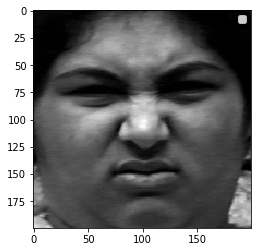

neutral


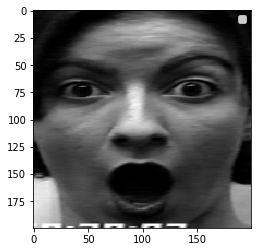

neutral


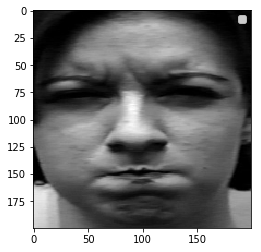

neutral


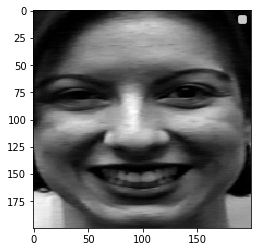

neutral


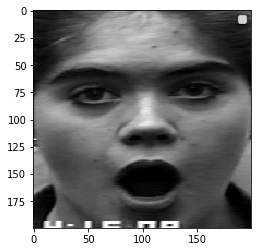

neutral


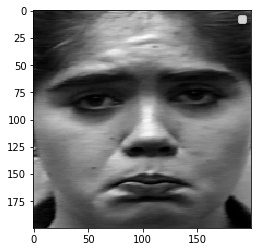

neutral


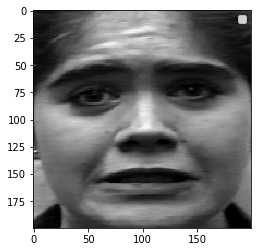

neutral


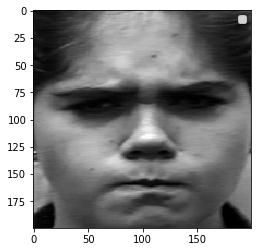

neutral


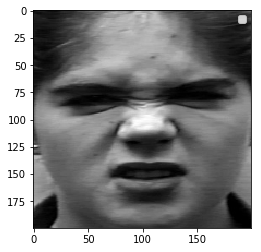

neutral


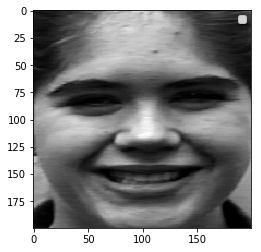

In [28]:
for i in range(10):
    plt.imshow(total_X[i], cmap='gray', )
    plt.legend([total_y[i]])
    print(y_translation[int(y_train[i][0])])
    plt.show()


## KERAS NEURAL NET

In [40]:
IMG_SIZE = 200
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(8, activation = 'softmax'))

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
